# Set up

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import calour as ca
ca.set_log_level(11)
%matplotlib inline

import numpy as np
np.random.seed(2018)

ca.__version__

'2019.5.1'

In [2]:
# Read data
cfs=ca.read_amplicon('data/otu_table.biom','data/metadata.txt', normalize=10000, min_reads=1000)

# Remove non-interesting bacteria with less than 10 reads over all the samples
cfs = cfs.filter_sum_abundance(10)

# Cluster the bacteria
cfs = cfs.cluster_features()

2024-09-23 12:50:53 INFO loaded 290 samples, 4572 features
2024-09-23 12:50:53 WARNING These have metadata but do not have data - dropped (1): {'524.ESC.1.54.OPR'}
2024-09-23 12:50:53 WARNING Do you forget to normalize your data? It is required before running this function
2024-09-23 12:50:53 INFO After filtering, 272 remain.
2024-09-23 12:50:53 INFO After filtering, 2171 remain.
2024-09-23 12:50:53 INFO After filtering, 2171 remain.


/Users/phuonganh/CAB420/CAB420_VENV/lib/python3.9/site-packages/calour/util.py:246: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not isinstance(exp.feature_metadata['taxonomy'][0], list):


# Task 1: Detail and justify choice of approach

### 1. Differential abundance analysis for feature selection

- Microbial datasets can be high-dimensional, with thousands of features and relatively few samples. Analysing all features indiscriminately can lead to overfitting and computational inefficiencies. Feature selection helps to reduce dimensionality by focusing on features that show significant differences, which can make the classification task more manageable and computationally efficient.
-  By selecting only those features that show significant differences, the classifier is trained on the most informative variables, reducing noise and improving its ability to distinguish between classes. This approach helps in building more robust and accurate predictive models by focusing on features that have strong associations with the outcome of interest.

### 2. Model selection

Multiple classification algorithms will be employed and evaluated. The approach involves fitting several classifiers, assessing their performance, and selecting the one with the highest accuracy. This methodology is grounded in the principle of model comparison to determine the most effective classifier for the given task.
- Random forest
- Logistic regression
- K-Nearest Neighbors
- Gradient Boosting

### 3. Data splitting strategy

- 70% of the data is used for training the model, while the remaining 30% is used for testing. This strategy provides an effective balance, ensuring that the model has enough data to learn from while retaining sufficient data to evaluate its generalizability. A 70-30 split is commonly used when working with datasets of moderate size.
- In addition, stratified sampling is implemented when splitting the data into training and testing sets. This ensures that the proportion of each class label (e.g., smokers vs. non-smokers) is maintained across both the training and testing sets.

### 4. Model evaluation

- Accuracy offers a simple and intuitive metric that gives an overall sense of how well the model is performing. 
- Confusion matrix provides a more granular view of the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives. This matrix helps evaluate how well the model is distinguishing between the two classes and identify any patterns of misclassification.
- Classification report summarises key metrics such as precision, recall, and F1-score for each class.

# Task 2: Predicts whether a person is a smoker based on nose samples

In [3]:
# Filter for nose site
cfs_nose = cfs.filter_samples('airwaysite', 'Nose')

# Sort the samples according to the smoking status
cfs_nose = cfs_nose.sort_samples('smoker')

# Perform diffential abundance
dd_nose = cfs_nose.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, random_seed=2018)

2024-09-23 12:50:54 INFO 136 samples with both values
2024-09-23 12:50:54 INFO After filtering, 1792 remain.
2024-09-23 12:50:54 INFO 67 samples with value 1 (['Yes'])
2024-09-23 12:50:55 INFO number of higher in Yes: 71. number of higher in No : 12. total 83


The differential abundance analysis identified 83 features that show significant differences between smokers and non-smokers group when using only nose samples. These features will be selected and subsequently used as input variables to build and train a classification model, enabling the distinction between the two groups based on their microbial composition.

In [4]:
# Convert the differential abundance data into a DataFrame
dense_matrix = dd_nose.data.toarray()  
dd_nose_df = pd.DataFrame(dd_nose.data.toarray())
dd_nose_df.columns = [f'OTU_{i}' for i in range(dense_matrix.shape[1])]

# Retrieve the metadata associated with the samples
metadata = dd_nose.sample_metadata

In [5]:
# Define X and y
X = dd_nose_df
y = metadata['smoker']

# Split the data using stratified sampling
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display accuracy for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)  
    y_pred = clf.predict(X_test_scaled) 
    accuracy = accuracy_score(y_test, y_pred)  
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.8293
Logistic Regression Accuracy: 0.7561
K-Nearest Neighbors Accuracy: 0.6341
Gradient Boosting Accuracy: 0.8780


After training and evaluating multiple classifiers, the Gradient Boosting Classifier was identified as the best performing model in terms of accuracy. This result suggests that Gradient Boosting is particularly effective at distinguishing between the two classes (smokers and non-smokers) for this given task.

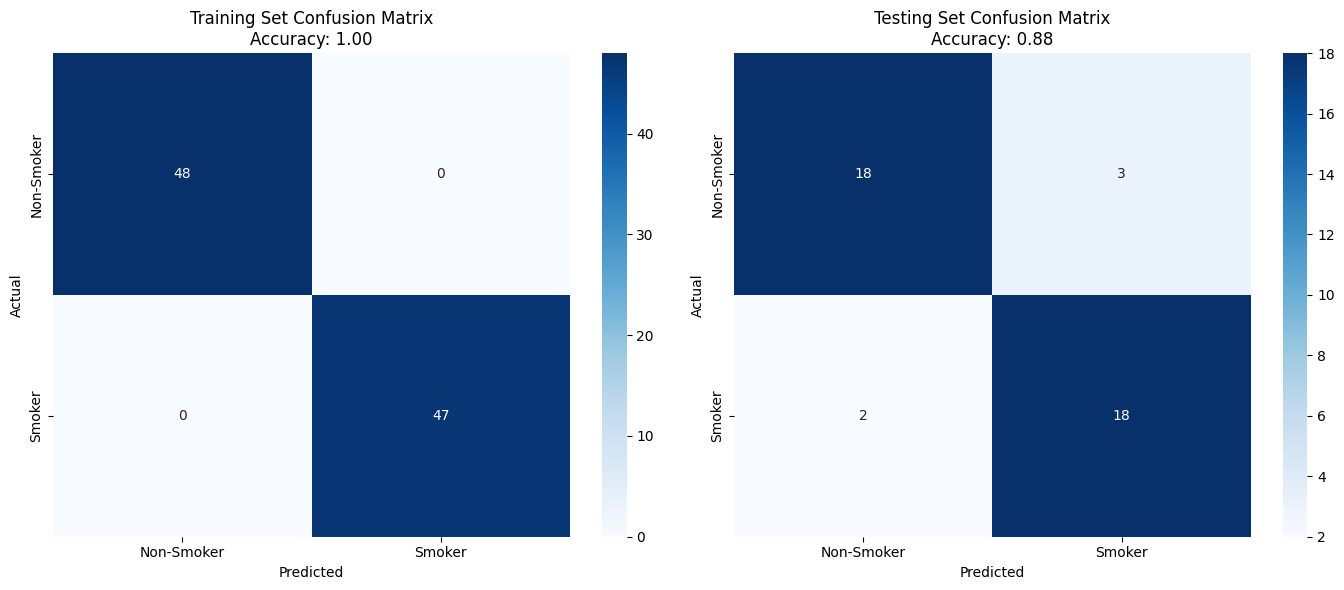

Classification Report:
               precision    recall  f1-score   support

          No       0.90      0.86      0.88        21
         Yes       0.86      0.90      0.88        20

    accuracy                           0.88        41
   macro avg       0.88      0.88      0.88        41
weighted avg       0.88      0.88      0.88        41



In [7]:
# Fit the Gradient Boosting classifier 
best_clf = classifiers['Gradient Boosting']
best_clf.fit(X_train_scaled, y_train)

# Make predictions on training and testing sets
y_train_pred = best_clf.predict(X_train_scaled)
y_test_pred = best_clf.predict(X_test_scaled)

# Compute accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.2f}')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Testing Set Confusion Matrix\nAccuracy: {test_accuracy:.2f}')

plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred))

## Discussion
- *Accuracy*: The model achieves perfect accuracy on the training set. However, its performance on the test set, while still strong at 88%, is lower than the training accuracy. This gap suggests the model may be overfitting, meaning it performs well on the training data but less so on testing data. The decrease in accuracy could also be due to the relatively small dataset size, which may limit the model’s ability to generalise effectively to new data.
- *Classification Report*: The model has a precision of 0.90 for predicting non-smokers and 0.86 for predicting smokers. This means the model is slightly better at minimising false positives for non-smokers. For recall, the model performs better in identifying smokers, with a recall of 0.90 for smokers compared to 0.86 for non-smokers. This suggests that the model is more effective at correctly identifying smokers. The identical F1-scores of 0.88 for both classes reflects that the model maintains a good balance between precision and recall for both non-smokers and smokers. The consistent F1-scores indicate that while there are differences in precision and recall, the model performs uniformly well across both classes.
- *Confusion Matrix*: The result indicates that the model correctly predicted 18 non-smokers and 18 smokers. However, it also shows 3 false positives, where non-smokers were incorrectly predicted as smokers, and 2 false negatives, where smokers were incorrectly predicted as non-smokers. There is only a slight tendency to misclassify non-smokers as smokers more frequently than the reverse which suggests that the model performs reasonably well overall. Thus, the model demonstrates a good balance in its predictions, effectively identifying both classes with relatively few errors.

# Task 3: Predicts whether a person is a smoker based on only throat samples

In [8]:
# Filter for throat site
cfs_throat = cfs.filter_samples('airwaysite', 'Throat')

# Sort the samples according to the smoking status
cfs_throat = cfs_throat.sort_samples('smoker')

# Perform diffential abundance
dd_throat = cfs_throat.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, random_seed=2018)

2024-09-23 12:50:56 INFO 136 samples with both values
2024-09-23 12:50:56 INFO After filtering, 1682 remain.
2024-09-23 12:50:56 INFO 68 samples with value 1 (['Yes'])
2024-09-23 12:50:58 INFO number of higher in Yes: 11. number of higher in No : 25. total 36


The differential abundance analysis identified 36 features that show significant differences between smokers and non-smokers group when using only throat samples. These features will be selected and subsequently used as input variables to build and train a classification model, enabling the distinction between the two groups based on their microbial composition.

In [9]:
# Convert the differential abundance data into a DataFrame
dense_matrix = dd_throat.data.toarray()  
dd_throat_df = pd.DataFrame(dense_matrix)
dd_throat_df.columns = [f'OTU_{i}' for i in range(dense_matrix.shape[1])]

# Retrieve the metadata associated with the samples
metadata = dd_throat.sample_metadata

In [10]:
# Define X and y
X = dd_throat_df
y = metadata['smoker']

# Split the data using stratified sampling
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train, predict, and display accuracy for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)  
    y_pred = clf.predict(X_test_scaled) 
    accuracy = accuracy_score(y_test, y_pred)  
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.7317
Logistic Regression Accuracy: 0.8537
K-Nearest Neighbors Accuracy: 0.7561
Gradient Boosting Accuracy: 0.8049


After training and evaluating multiple classifiers, the Logistic Regression was identified as the best performing model in terms of accuracy. This result suggests that Logistic Regression is particularly effective at distinguishing between the two classes (smokers and non-smokers) for this given task.

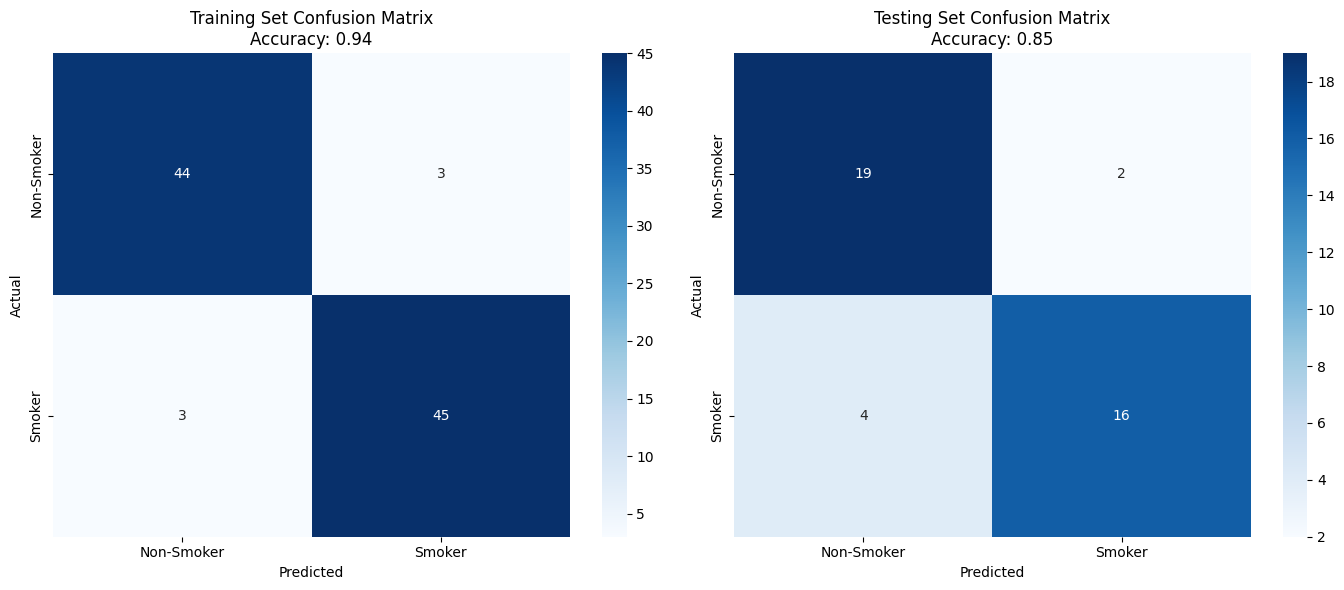

Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.90      0.86        21
         Yes       0.89      0.80      0.84        20

    accuracy                           0.85        41
   macro avg       0.86      0.85      0.85        41
weighted avg       0.86      0.85      0.85        41



In [12]:
# Fit the Logistic Regression classifier
best_clf = classifiers['Logistic Regression']
best_clf.fit(X_train_scaled, y_train)

# Make predictions on training and testing sets
y_train_pred = best_clf.predict(X_train_scaled)
y_test_pred = best_clf.predict(X_test_scaled)

# Compute accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.2f}')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Testing Set Confusion Matrix\nAccuracy: {test_accuracy:.2f}')

plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred))

## Discussion

- *Accuracy*: The model achieves a high accuracy of 94% on the training set, indicating that it performs well on the data it was trained on. However, the accuracy drops to 85% on the testing set. This drop mirrors the trend observed in the previous model in Task 2, where the difference in accuracy between training and testing phases indicated overfitting and issues related to a small dataset. 
- *Classification Report*: The classification report indicates that the model has a precision of 0.83 for predicting non-smokers and 0.89 for predicting smokers. This suggests that the model is slightly better at accurately identifying smokers than non-smokers. In terms of recall, the model performs better in identifying non-smokers with a recall of 0.90, compared to a recall of 0.80 for smokers. The F1-scores reflect a balanced performance, with non-smokers achieving an F1-score of 0.86 and smokers achieving an F1-score of 0.84. The macro and weighted averages of 0.85 further demonstrate a solid overall performance, indicating that the model maintains a good balance between precision and recall across both classes.
- *Confusion Matrix*: The confusion matrix reveals that the model correctly predicted 19 non-smokers and 16 smokers. It also shows 2 false positives, where non-smokers were incorrectly predicted as smokers, and 4 false negatives, where smokers were incorrectly predicted as non-smokers. The higher number of False Negatives (4) compared to False Positives (2) indicates that the model is more likely to incorrectly classify smokers.

# Task 4: Predicts whether a person is a smoker based on the two sample types

In [13]:
# Sort the samples according to the smoking status
cfs_combined = cfs.sort_samples('smoker')

# Perform diffential abundance
dd=cfs_combined.diff_abundance('smoker','Yes','No', fdr_method='dsfdr', alpha = 0.05, random_seed=2018)

2024-09-23 12:50:58 INFO 272 samples with both values
2024-09-23 12:50:58 INFO After filtering, 2171 remain.
2024-09-23 12:50:58 INFO 135 samples with value 1 (['Yes'])
2024-09-23 12:51:01 INFO number of higher in Yes: 57. number of higher in No : 18. total 75


The differential abundance analysis identified 75 features that show significant differences between smokers and non-smokers group when using samples from both nose and throat. These features will be selected and subsequently used as input variables to build and train a classification model, enabling the distinction between the two groups based on their microbial composition.

In [14]:
# Convert the differential abundance data into a DataFrame
dense_matrix = dd.data.toarray()  
dd_df = pd.DataFrame(dense_matrix)
dd_df.columns = [f'OTU_{i}' for i in range(dense_matrix.shape[1])]

# Retrieve the metadata associated with the samples
metadata = dd.sample_metadata

In [15]:
# Define X and y
X = dd_df
y = metadata['smoker']

# Split the data using stratified sampling
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Train, predict, and display accuracy for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)  
    y_pred = clf.predict(X_test_scaled) 
    accuracy = accuracy_score(y_test, y_pred)  
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.7195
Logistic Regression Accuracy: 0.7927
K-Nearest Neighbors Accuracy: 0.6951
Gradient Boosting Accuracy: 0.7195


After training and evaluating multiple classifiers, the Logistic Regression was identified as the best performing model in terms of accuracy. This result suggests that Logistic Regression is particularly effective at distinguishing between the two classes (smokers and non-smokers) for this given task.

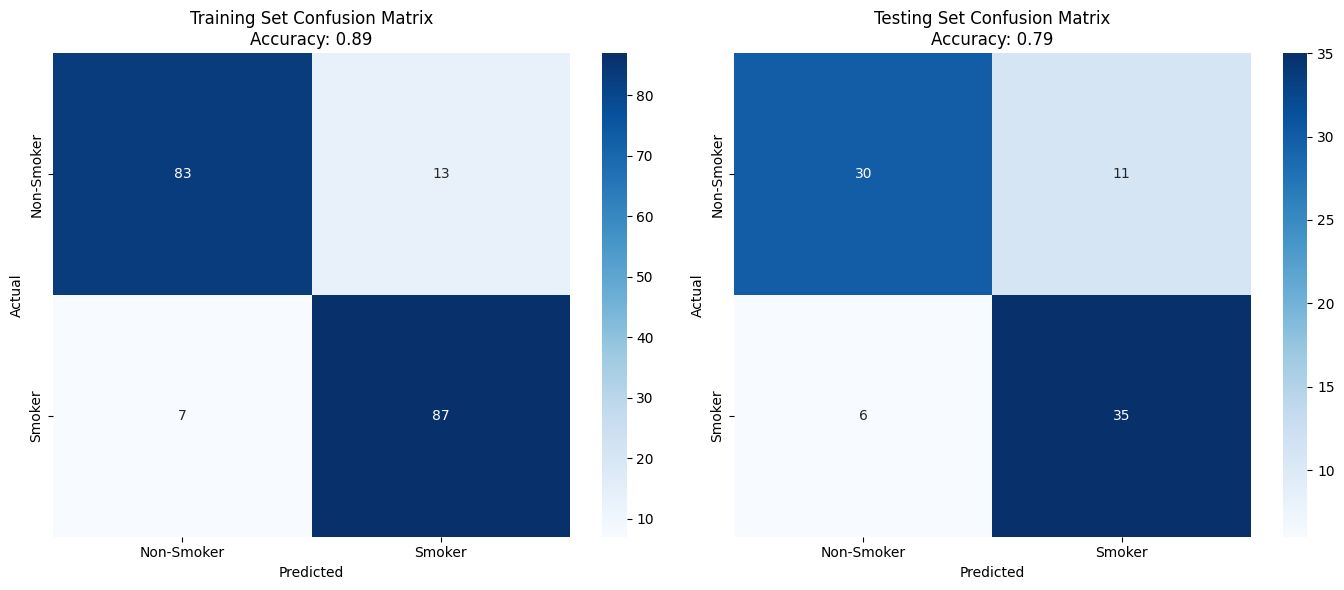

Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.73      0.78        41
         Yes       0.76      0.85      0.80        41

    accuracy                           0.79        82
   macro avg       0.80      0.79      0.79        82
weighted avg       0.80      0.79      0.79        82



In [17]:
# Fit the Logistic Regression  classifier
best_clf = classifiers['Logistic Regression']
best_clf.fit(X_train_scaled, y_train)

# Make predictions on training and testing sets
y_train_pred = best_clf.predict(X_train_scaled)
y_test_pred = best_clf.predict(X_test_scaled)

# Compute accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.2f}')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Testing Set Confusion Matrix\nAccuracy: {test_accuracy:.2f}')

plt.tight_layout()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred))

## Discussion

- *Accuracy*: The model shows a notable decrease in accuracy from 89% on the training set to 79% on the testing set. This drop indicates that while the model performs well on the data it was trained on, it faces challenges generalising to new, unseen data. This drop mirrors the trend observed in previous two tasks, where the difference in accuracy between training and testing phases indicated overfitting and issues related to a small dataset.
- *Classification Report*: The classification report shows that the model has a precision of 0.83 for predicting non-smokers and 0.76 for predicting smokers. This indicates that the model is better at minimising false positives. In terms of recall, the model performs better in identifying smokers with a recall of 0.85, compared to a recall of 0.73 for non-smokers. The F1-scores are relatively close, with non-smokers achieving 0.78 and smokers achieving 0.80, reflecting a balanced performance across both classes. The macro and weighted averages of 0.79 further suggest that while the model has strengths in identifying both classes, there is room for improvement.
- *Confusion Matrix*: The confusion matrix reveals 11 false positives, where non-smokers incorrectly predicted as smokers, and 6 false negatives, where smokers incorrectly predicted as non-smokers. This imbalance highlights that the model is more effective at identifying smokers but has some difficulty in distinguishing non-smokers accurately.
- *Compared with Task 2 and 3*: The performance of the model predicting smokers based on both nose and throat samples shows a decrease in accuracy on the testing set (79%) compared to the individual models that predicted based on nose samples (88%) and throat samples (85%). This drop in accuracy may be attributed to differences in distributions and characteristics between nose and throat samples. Combining features from different sites without considering their specific contexts might lead to the model missing important site-specific patterns. Features that are highly relevant in one context might not be as informative when combined with features from another site, which can result in reduced overall performance. As the model does not account for these differences, it may struggle to generalise across the combined data. 